In [77]:
import pandas as pd
import os, re
import json
import ast
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns


In [2]:
os.listdir("./tempdir")

['Annual turnover from organisation benchmarking source data, February 2023.csv',
 'inactive_organisations.txt',
 'Monthly turnover from organisation benchmarking source data, February 2023.csv',
 'processed_annual_data.csv',
 'processed_monthly_data.csv',
 'turnover.zip']

In [3]:
annual_csv = [f for f in os.listdir('./tempdir') if re.match(r"(?i)^annual", f)]
monthly_csv = [f for f in os.listdir('./tempdir') if re.match(r"(?i)^monthly", f)]

In [4]:
annual_csv

['Annual turnover from organisation benchmarking source data, February 2023.csv']

In [5]:
monthly_csv

['Monthly turnover from organisation benchmarking source data, February 2023.csv']

In [6]:
with open('./tempdir/inactive_organisations.txt', 'r') as file:
    # Read the contents of the file
    data = json.load(file)
    js_df = converted_dict = {row['org_id']: row['name'] for row in data}

file.close()


In [7]:
annual_df = pd.read_csv(f"./tempdir/{annual_csv[0]}")
monthly_df = pd.read_csv(f"./tempdir/{monthly_csv[0]}")

In [23]:
annual_df.head()

,Period,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE
0,31/01/2022,Denoms,00Q,NHS Blackburn with Darwen CCG,Y62,North West,QE1,Lancashire and South Cumbria,Clinical Commissioning Group,Clinical Commissioning Group,Nurses & health visitors,4,3.10000
1,31/01/2022,Denoms,00Q,NHS Blackburn with Darwen CCG,Y62,North West,QE1,Lancashire and South Cumbria,Clinical Commissioning Group,Clinical Commissioning Group,"Scientific, therapeutic & technical staff",6,5.33334
2,31/01/2022,Denoms,00Q,NHS Blackburn with Darwen CCG,Y62,North West,QE1,Lancashire and South Cumbria,Clinical Commissioning Group,Clinical Commissioning Group,Senior managers,11,7.07254
3,31/01/2022,Denoms,00R,NHS Blackpool CCG,Y62,North West,QE1,Lancashire and South Cumbria,Clinical Commissioning Group,Clinical Commissioning Group,Managers,24,22.18000
4,31/01/2022,Denoms,00T,NHS Bolton CCG,Y62,North West,QOP,Greater Manchester,Clinical Commissioning Group,Clinical Commissioning Group,Nurses & health visitors,16,14.55333


In [9]:
monthly_df.head()

,Period,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE
0,202112 to 202201,Leavers,RXX,Surrey and Borders Partnership NHS Foundation ...,Y59,South East,QXU,Surrey Heartlands,Mental Health,Mental Health and Learning Disability,All staff groups,46,41.09334
1,202112 to 202201,Leavers,RJ2,Lewisham and Greenwich NHS Trust,Y56,London,QKK,South East London,Acute,Acute - Large,All staff groups,112,101.00739
2,202112 to 202201,Leavers,RDR,Sussex Community NHS Foundation Trust,Y59,South East,QNX,Sussex,Community Provider Trust,Community Provider Trust,All staff groups,86,67.40329
3,202112 to 202201,Leavers,26A,NHS Norfolk and Waveney CCG,Y61,East of England,QMM,Norfolk and Waveney,Clinical Commissioning Group,Clinical Commissioning Group,All staff groups,9,8.20000
4,202112 to 202201,Leavers,RWX,Berkshire Healthcare NHS Foundation Trust,Y59,South East,QNQ,Frimley,Mental Health,Mental Health and Learning Disability,All staff groups,73,60.87147


In [41]:
def process_turnover_df(df):
    df1 = pd.DataFrame(df)
    
    # df1['date_string'] = df1['Period'].apply(lambda x: x.split(' to ')[-1]+'01' if x.endswith(('Leavers', 'Joiners')) else ('01/'+x[3:10] if x.startswith('Denoms') else None))
    #df1['thedate'] = pd.to_datetime(datetime.now())

    df1['thedate'] = df1.apply(lambda x: datetime.strptime(x['Period'].split(' to ')[0]+'01', '%Y%m%d') 
                               if x['Type'] in ('Leavers', 'Joiners') else (datetime.strptime('01/'+x['Period'][3:10], '%d/%m/%Y') 
                                                                            if x['Type'] == 'Denoms' else None), axis = 1)   
    
    df2 = df1.groupby(['Org code','NHSE region name','Benchmark group', 'Staff group', 'thedate']).apply(lambda x: 
        pd.Series({
        'n': x.shape[0],
        'join_HC': x.loc[x['Type'].str.contains('Joiners'), 'HC'].values[0] if any(x['Type'] == 'Joiners') else None,
        'join_FTE': x.loc[x['Type'] == 'Joiners', 'FTE'].values[0] if any(x['Type'] == 'Joiners') else None,
        'leave_HC': x.loc[x['Type'] == 'Leavers', 'HC'].values[0] if any(x['Type'] == 'Leavers') else None,
        'leave_FTE': x.loc[x['Type'] == 'Leavers', 'FTE'].values[0] if any(x['Type'] == 'Leavers') else None,
        'denom_HC': x.loc[x['Type'] == 'Denoms', 'HC'].values[0] if any(x['Type'] == 'Denoms') else None,
        'denom_FTE': x.loc[x['Type'] == 'Denoms', 'FTE'].values[0] if any(x['Type'] == 'Denoms') else None,
    })).reset_index().rename(columns={
        'Org code': 'org_code',
        'Staff group': 'staff_group',
        'thedate': 'month_year',
        'NHSE region name':'region_name',
        'Benchmark group':'org_type'
    }).drop_duplicates()

    # Drop CCGs and ICBs
    df3 = df2[~df2['org_type'].isin(['Clinical Commissioning Group','Integrated Care Board'])]


    return df3


In [42]:
processed_annual_df = process_turnover_df(annual_df) 
processed_annual_df.shape[0]


177121

In [51]:
processed_annual_df.head()


,org_code,region_name,org_type,staff_group,month_year,n,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE
68771,R0A,North West,Acute - Teaching,All staff groups,2017-08-01,1.0,19807.0,17688.67573,NaN,NaN,NaN,NaN
68772,R0A,North West,Acute - Teaching,All staff groups,2017-09-01,1.0,19929.0,17827.49574,NaN,NaN,NaN,NaN
68773,R0A,North West,Acute - Teaching,All staff groups,2017-10-01,3.0,3184.0,2970.05107,2229.0,1977.21981,19130.0,17095.95832
68774,R0A,North West,Acute - Teaching,All staff groups,2017-11-01,3.0,3217.0,2998.30542,2246.0,1993.80584,19211.0,17171.25859
68775,R0A,North West,Acute - Teaching,All staff groups,2017-12-01,3.0,3238.0,3027.06813,2256.0,2000.86500,19214.0,17170.86679


In [59]:
processed_annual_df.loc[processed_annual_df['org_code'] == 'R0A'].sort_values(by=['n', 'month_year'], ascending=False).head()

,org_code,region_name,org_type,staff_group,month_year,n,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE
68825,R0A,North West,Acute - Teaching,All staff groups,2022-02-01,3.0,4230.0,3959.99032,3592.0,3170.66348,26738.0,24140.00946
68930,R0A,North West,Acute - Teaching,Central functions,2022-02-01,3.0,426.0,402.82256,404.0,378.56744,2341.0,2180.98659
68997,R0A,North West,Acute - Teaching,HCHS doctors (exc. junior Drs),2022-02-01,3.0,140.0,112.95000,130.0,107.73136,1646.0,1512.03278
69064,R0A,North West,Acute - Teaching,"Hotel, property & estates",2022-02-01,3.0,146.0,126.02664,92.0,77.44668,850.0,729.22940
69131,R0A,North West,Acute - Teaching,Managers,2022-02-01,3.0,35.0,34.30000,20.0,19.58666,277.0,268.79601


In [81]:
processed_annual_df['month_year'].unique()

<DatetimeArray>
['2017-08-01 00:00:00', '2017-09-01 00:00:00', '2017-10-01 00:00:00',
 '2017-11-01 00:00:00', '2017-12-01 00:00:00', '2018-01-01 00:00:00',
 '2018-02-01 00:00:00', '2018-03-01 00:00:00', '2018-04-01 00:00:00',
 '2018-05-01 00:00:00', '2018-06-01 00:00:00', '2018-07-01 00:00:00',
 '2018-08-01 00:00:00', '2018-09-01 00:00:00', '2018-10-01 00:00:00',
 '2018-11-01 00:00:00', '2018-12-01 00:00:00', '2019-01-01 00:00:00',
 '2019-02-01 00:00:00', '2019-03-01 00:00:00', '2019-04-01 00:00:00',
 '2019-05-01 00:00:00', '2019-06-01 00:00:00', '2019-07-01 00:00:00',
 '2019-08-01 00:00:00', '2019-09-01 00:00:00', '2019-10-01 00:00:00',
 '2019-11-01 00:00:00', '2019-12-01 00:00:00', '2020-01-01 00:00:00',
 '2020-02-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00',
 '2020-05-01 00:00:00', '2020-06-01 00:00:00', '2020-07-01 00:00:00',
 '2020-08-01 00:00:00', '2020-09-01 00:00:00', '2020-10-01 00:00:00',
 '2020-11-01 00:00:00', '2020-12-01 00:00:00', '2021-01-01 00:00:00',
 '20

In [46]:
processed_monthly_df = process_turnover_df(monthly_df) 
processed_monthly_df.shape[0]

145156

In [54]:
processed_annual_df['month_year'] = pd.to_datetime(processed_annual_df['month_year'])

In [71]:
test = processed_annual_df.groupby(['month_year','staff_group']).agg({'leave_FTE':'sum','denom_FTE':'sum'}).reset_index()
#test = processed_annual_df.groupby(['month_year','staff_group']).sum().reset_index()

In [73]:
test['rate'] = test['leave_FTE']/test['denom_FTE']

In [79]:
test_a =  test[test['staff_group'] == 'All staff groups']

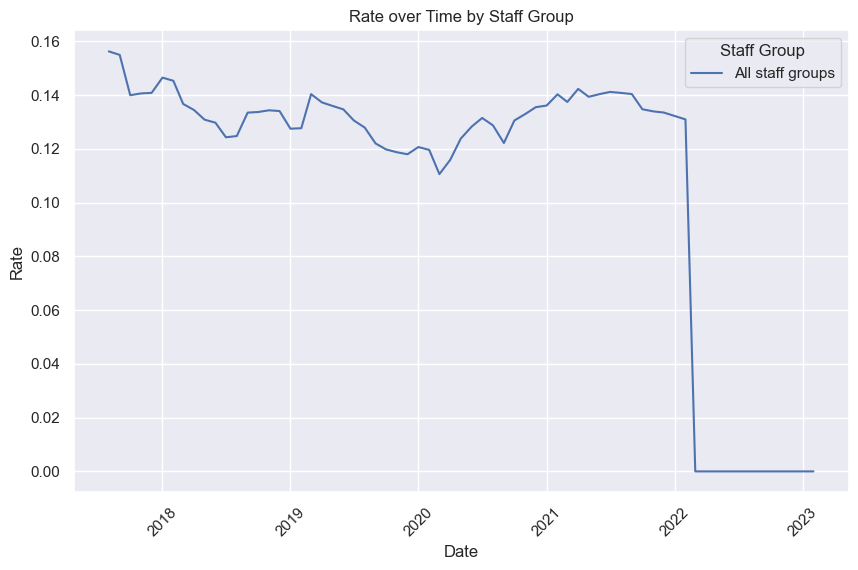

In [80]:
sns.set()

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(data=test_a, x='month_year', y='rate', hue='staff_group')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Rate over Time by Staff Group')
plt.legend(title='Staff Group', loc='best')  # Add legend with the title 'Staff Group'
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
plt.show()

In [15]:
processed_annual_df.to_csv('./tempdir/processed_annual_data.csv', index=False)
#processed_monthly_df.to_csv('./tempdir/processed_monthly_data.csv', index=False)

In [20]:
processed_monthly_df.to_csv('../processed_monthly_turnover.csv', index=False)